# Deep Learning Bootcamp

## To edit this notebook, go to File -> Save a copy in Drive

Google Colab is a freemium cloud service based on Jupyter notebooks. It provides a virtual machine (VM) in which a Jupyter notebook can be executed, even with hardware acceleration like GPUs. The whole process is similar to Google borrowing us one of its computers. We can access this borrowed computer through this browser window.



## What is a Jupyter Notebook?


A Jupyter Notebook is a basically a nice looking web interface for the interactive Python interpreter. Interactive coding differs from classical coding. Instead of executing the whole program at once, you can execute small code cells in a sequential way. You can think of Jupyter Notebook as a chalk board. With each code cell, we we write something onto the chalk board. As long as we don't restart Notebook (=wiping the chalk board), we keep the changes made to our Notebook. This especially means that we don't have to execute previous code cells again and again if we make changes in subsequent cells. This also means that we have to execute previous code cells again (=overwriting the text written onto the chalk board) if we made changes to them.

Jupyter Notebooks also allow text cells. With the text cells, we can create interactive code stories in which you can play around and experiment with the theory provided in the text cell. There even exist whole books written as Jupyter Notebooks!



In [ ]:
a = 10
b= 25

In [ ]:
product = a * b
sum = a + b
result = product * sum
print(result)

8750


## GPU Runtimes

In order to use a GPU in our VM, we have to allocate a GPU runtime. You can do this in the menu bar -> Runtime -> Change runtime type -> Hardware accelerator -> GPU

To check if we really have a GPU and what type it is, we can use the linux commang 'nvidia-smi'. Nvidia SMI is a monitoring tool for Nvidia GPUs.

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Mon Apr 29 10:45:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data Loading

A virtual machine is the simultion of a computer operating system (e.g. Windows or Linux) on another computer. Basically, it allows you to run an OS inside another OS. Mac Users may know this from Parallels Desktop, which allows to use Windows inside of Mac OS. Because a VM acts as another computer (that is trapped inside another computer), we have download our dataset inside this virtual computer system. We can again do this using linux commands. **You don't have to understand the following code, it's enough to understand that you can operate a computer entirely using a command line, which includes downloading and unzipping zip-files.**

In [ ]:
import time
import numpy as np
import os
import PIL
from PIL import Image
#import tensorflow as tf
from pathlib import Path
import pandas

#from tensorflow import keras
#from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


! apt install p7zip-full

print("Uploading data to Colab...")
start_time = time.time()
!wget 'https://faubox.rrze.uni-erlangen.de/dl/fiTCnufF4PbtbTwA7uUMsQ/traffic_sign.zip' -O 'traffic_sign.zip' # Here we download our zip file
exec_time = time.time() - start_time
print(f"Time to Upload: {round(exec_time, 2)} sec")
!ls # We can take a look at our local directories with this command
print("Unpacking...")
start_time = time.time()
!7z x traffic_sign.zip  # Here we unpack the donwloaded file into a local folder
exec_time = time.time() - start_time
print(f"Time to Unpack: {round(exec_time, 2)} sec")

!ls

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Uploading data to Colab...
--2024-04-29 10:45:41--  https://faubox.rrze.uni-erlangen.de/dl/fiTCnufF4PbtbTwA7uUMsQ/traffic_sign.zip
Resolving faubox.rrze.uni-erlangen.de (faubox.rrze.uni-erlangen.de)... 131.188.10.71
Connecting to faubox.rrze.uni-erlangen.de (faubox.rrze.uni-erlangen.de)|131.188.10.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320055701 (305M) [application/x-zip-compressed]
Saving to: ‘traffic_sign.zip’

traffic_sign.zip    100%[===================>] 305.23M  25.1MB/s    in 13s     

2024-04-29 10:45:54 (23.4 MB/s) - ‘traffic_sign.zip’ saved [320055701/320055701]

Time to Upload: 14.22 sec
sample_data  traffic_sign.zip
Unpacking...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (local

In [ ]:
#### Config ####
image_size = 45
num_classes = 43
#################

## A small data pipeline

Our idea: we want to map paths of singke images from the *.csv file to transformed images.

### Converting a single path to a loaded image

Our first functions simply loads a single file path and resizes it. For loading the images, we use the Image module from PIL, a package for handling images. Because all images need to have the same size, we use PIL again to resize the loaded image to a prevoiously defined size. For our late use, we want to have the images in a numpy format, therefore we transform our image into a numpy image.

### Loading all files from a csv file

In order to read all files from our *.csv files, we have to load them in our prorgram first. To load a *.csv file, we use pandas, a package specifically designed for tabular data. We exract the column containing the labels first. Then we create a one-hot encoding for them to match the logits structure of our neural networks. Now we can start creating the huge matrix containing all loaded and resized images. First, we extract the column containing the image paths. Then we iterate over all paths and apply our conversion function to every single path. Now that we are done loding our data, we can return the images and labels.


In [ ]:
def convert_path_to_image(path, image_size=image_size):
    temp = Image.open(path)
    img = temp.copy()
    temp.close()

    img = img.resize((image_size, image_size))
    return np.array(img)

def load_csv(csv_path, root_path):
    data_frame = pandas.read_csv(csv_path)

    label_ints = data_frame.pop('ClassId').to_numpy()
    labels = np.zeros((label_ints.size, label_ints.max()+1)) # one hot encoding. Here we do the shape
    labels[np.arange(label_ints.size), label_ints] = 1       # arange: list of all x indices, label ints contains all indeces in y -> we want to set all these to 1

    img_paths = data_frame.pop('Path').to_numpy()
    images = np.array([convert_path_to_image(root_path / p) for p in img_paths])

    return images, labels

def plot_images(images, labels, n=3):
    indices = np.random.randint(len(images), size=n)

    for i in indices:
        print(i)
        print(f"Label: {np.argmax(labels[i])}")
        print(f"One hot label: {labels[i]}")
        plt.imshow(images[i])
        plt.show()

(39209, 45, 45, 3)
(39209, 43)
(12630, 45, 45, 3)
(12630, 43)
21399
Label: 13
One hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


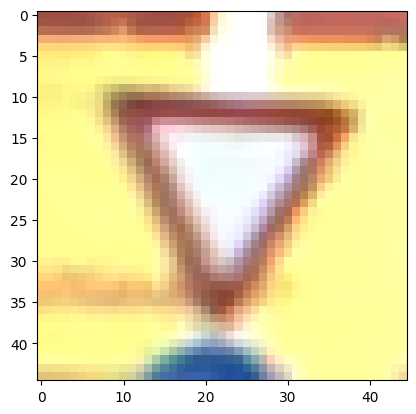

34102
Label: 34
One hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


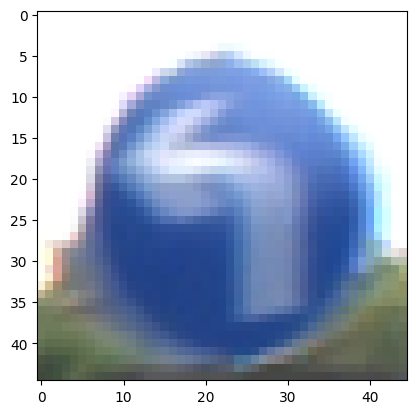

8435
Label: 5
One hot label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


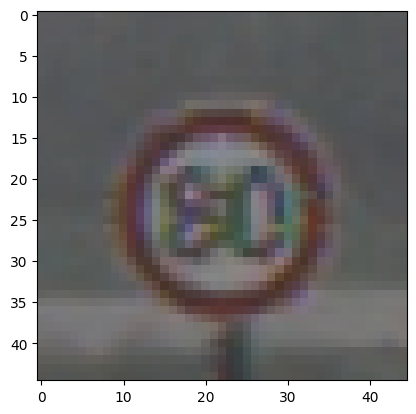

In [ ]:
"""
Method from https://www.tensorflow.org/tutorials/load_data/images
"""

data_root_path = Path('./traffic_sign')
train_path = data_root_path / 'Train.csv'
test_path = data_root_path / 'Test.csv'

train_images, train_labels = load_csv(train_path, data_root_path)
print(train_images.shape)
print(train_labels.shape)

test_images, test_labels = load_csv(test_path, data_root_path)
print(test_images.shape)
print(test_labels.shape)

plot_images(train_images, train_labels)

## Our models

### Fully connected network

This is the most simple network. We start with flattening our inputs. Then we gradually decrease the dimensionality of the internal feature vector. Our last layer has num_classes neurons because we want create a one-hot encoding of our outputs.

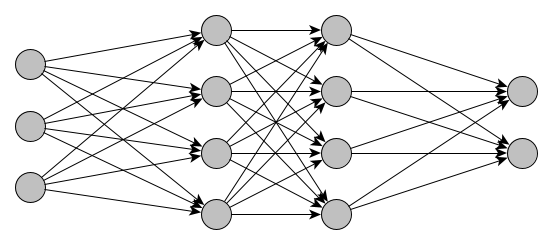

In [ ]:
from tensorflow import keras
from keras import layers
print(train_images.shape)
print(num_classes)

def fully_connected_net(input_dim = (image_size, image_size, 3), num_classes=num_classes):
    model = keras.Sequential([
        keras.Input(shape=input_dim),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

(39209, 45, 45, 3)
43


### Small Convolutional Network

The small convolutional network aims to solve the problems occuring with fully connected networks. This network is split in two parts: feature extraction using convolutional layers and the decision part using fully connected layers. In the feature extraction part, we use two convolutional layers two extract a 16 channel deep feature map. The we flatten this layer and let 3 fully connected layers learn to classify the extracted features.

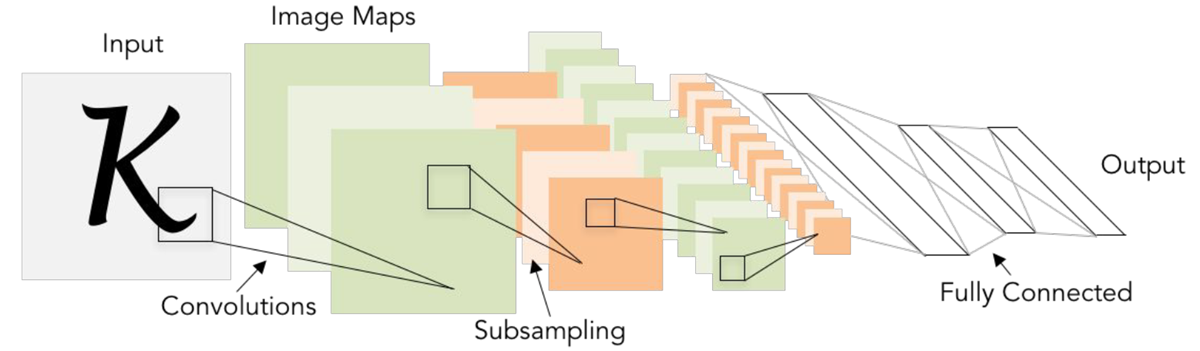

In [ ]:
def small_conv_net(input_dim = (image_size, image_size, 3), num_classes=num_classes):
    model = keras.Sequential([
        keras.Input(shape = input_dim ),
        layers.Conv2D(filters=6, kernel_size=(3,3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters = 16, kernel_size=(5,5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(120, activation="relu"),
        layers.Dense(80, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [ ]:
cnn = small_conv_net()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43, 43, 6)         168       
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 21, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 120)               1

In [ ]:
def medium_conv_net(num_classes=num_classes):
    pass

In [ ]:
def large_conv_net(num_classes=num_classes):
    pass

### Using a pretrained model

This would be the go-to-approach in real life. For this example, we use ResNet-50 v2. In order to use the model, we have to change the input dimensions of the model. Then again we can classify the extracted features.

In [ ]:
def pretrained_model(num_classes=num_classes):
    base_model = keras.applications.ResNet50V2(
        include_top = False,
        weights= "imagenet",
        input_shape=(image_size, image_size, 3)
    )
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=True)
    x= keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model



## Training our model

Keras hides most of the work necessary for training neural networks. But we still have to define some parts. First, we instantiate our model. Then we define the training algorithms that optimizes our parameters and the loss functions that should be minimized. Now we can compile the model. You can see this as glueing together the components for the training. Here we also tell keras that we want to use the accuracy metric for evaluation. Finally, we can call the .fit method with our dataset as parameter. The .fit methods trains our networks by iterating num_epoch times over the dataset, that is split in small batch_size large pieces.

In [ ]:
#### Config ####
batch_size = 64
num_epochs = 10
learning_rate = 0.0001
#################

In [ ]:
# train the model
#model = fully_connected_net()
# model = small_conv_net()
model = pretrained_model()
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 45, 45, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 43)                352299    
                                                                 
Total params: 23917099 (91.24 MB)
Trainable params: 23871659 (91.06 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
opt = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
#model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,  validation_data=(test_images, test_labels))

Epoch 1/10
613/613 [==============================] - 77s 70ms/step - loss: 0.7880 - accuracy: 0.7846 - val_loss: 0.5262 - val_accuracy: 0.8472
Epoch 2/10
613/613 [==============================] - 40s 66ms/step - loss: 0.0472 - accuracy: 0.9855 - val_loss: 0.4182 - val_accuracy: 0.8908
Epoch 3/10
613/613 [==============================] - 39s 64ms/step - loss: 0.0224 - accuracy: 0.9930 - val_loss: 0.3947 - val_accuracy: 0.9016
Epoch 4/10
613/613 [==============================] - 39s 64ms/step - loss: 0.0167 - accuracy: 0.9953 - val_loss: 0.3254 - val_accuracy: 0.9167
Epoch 5/10
613/613 [==============================] - 39s 64ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 0.2807 - val_accuracy: 0.9348
Epoch 6/10
613/613 [==============================] - 42s 68ms/step - loss: 0.0172 - accuracy: 0.9952 - val_loss: 0.3011 - val_accuracy: 0.9249
Epoch 7/10
613/613 [==============================] - 42s 68ms/step - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.2598 - val_accuracy:

## Evaluating our model

Since we finished training our model, we want to know its ability to generalize. Therefore, we load our test dataset with unseen instances and pass it to the .evaluate function. To get a better understanding about our model's abilieties, we want so visualize its predictions on the unseen test dataset in a confusion matrix. To calculate the confusion matrix, we use scikit-learn (short: sklearn), which is an excellent framework for classical machine learning. To plot the confusion matrix, we use the built-in functions of sklearn.

395/395 [==============================] - 6s 13ms/step


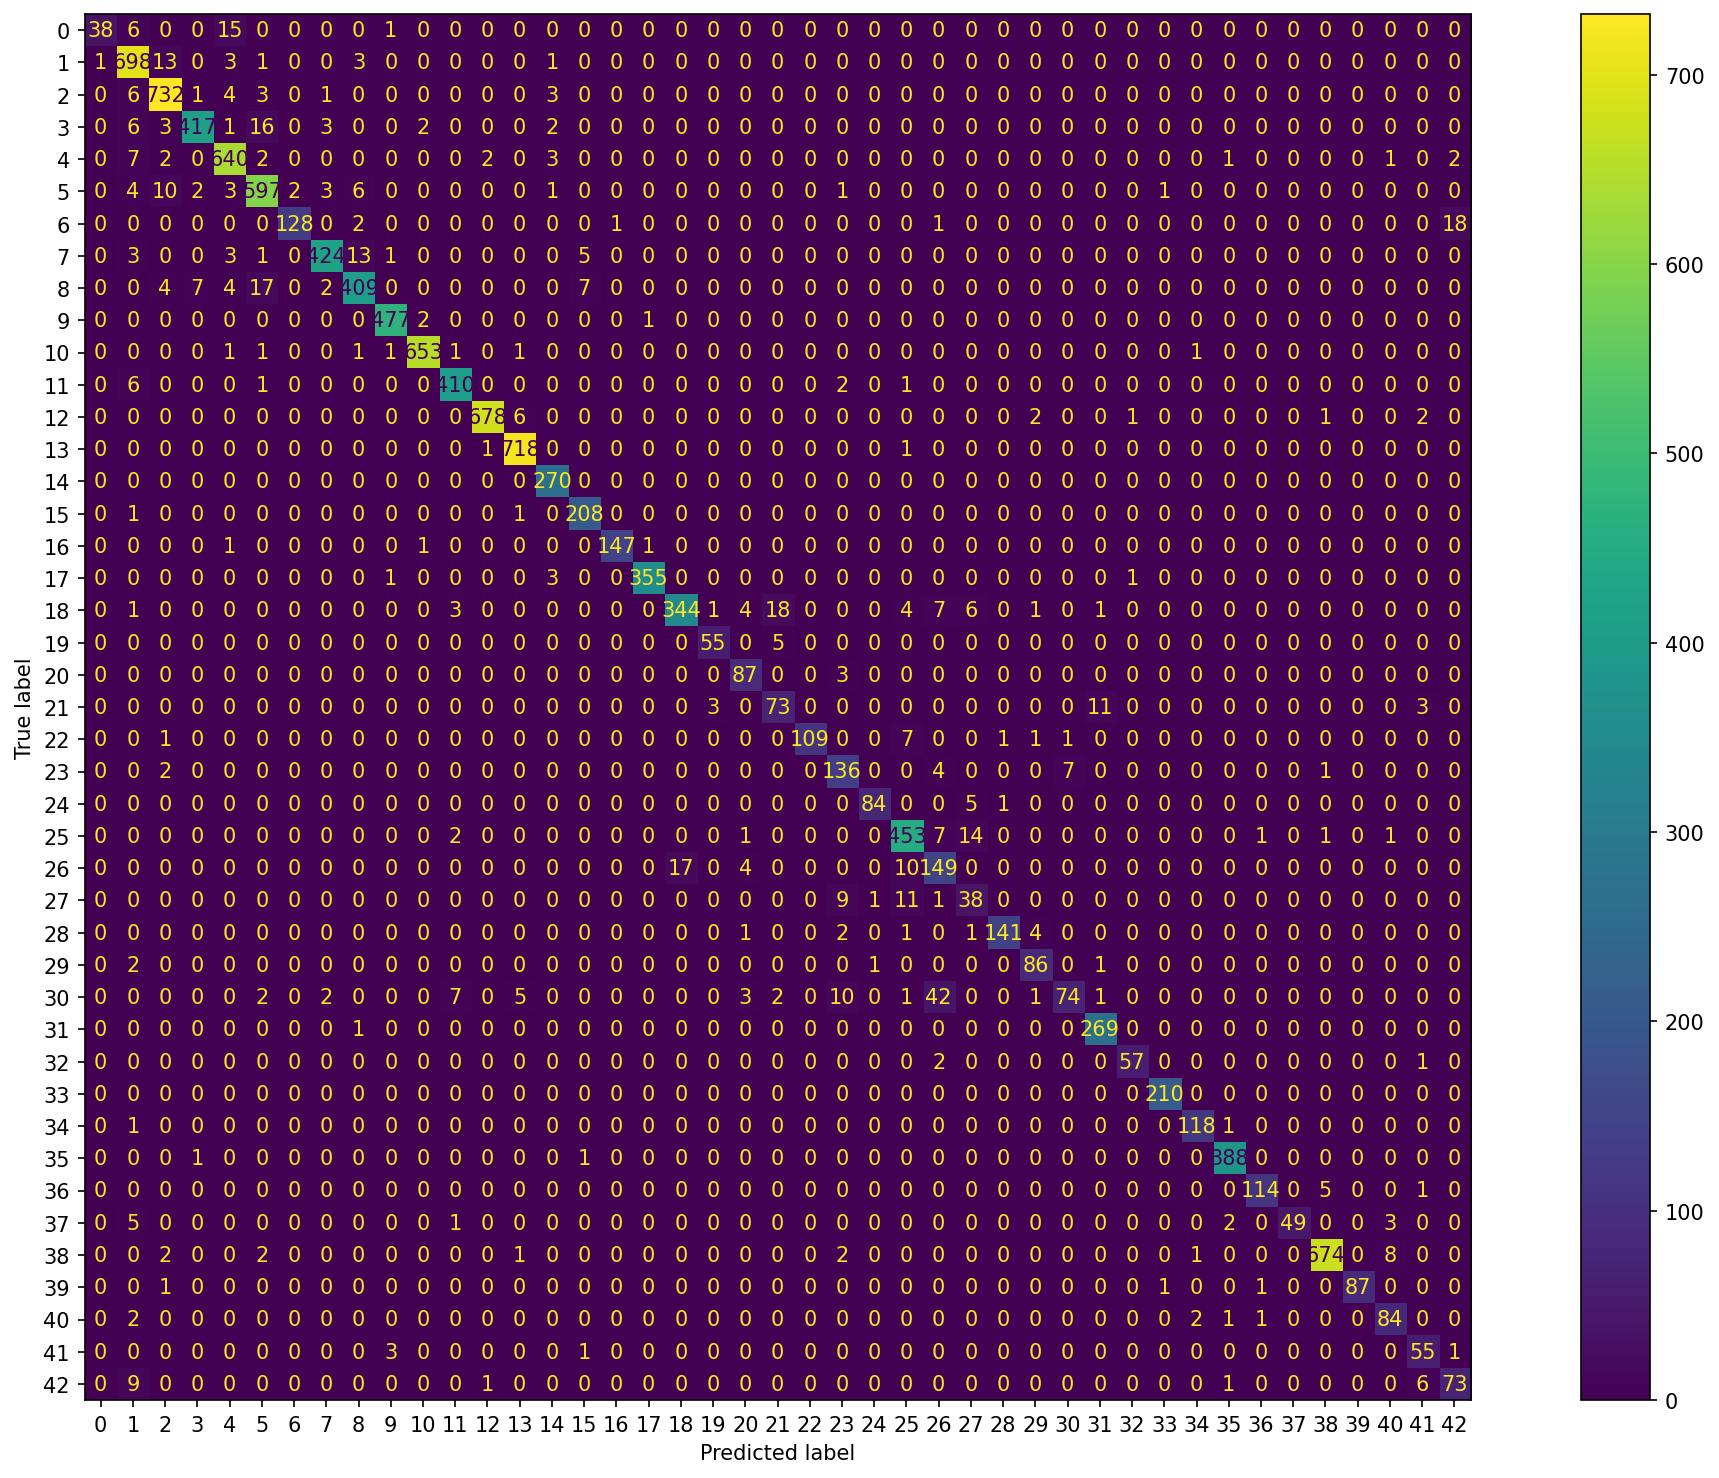

In [ ]:
model.evaluate(test_images, test_labels)

predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predictions)

# just for better presentation - but store original values
default_figsize = plt.rcParams['figure.figsize']
default_dpi = plt.rcParams['figure.dpi']

plt.rcParams['figure.figsize'] = [19, 12]
plt.rcParams['figure.dpi'] = 150

display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(43))
display.plot(values_format='-')
plt.show()

# set back to original values
plt.rcParams['figure.figsize'] = default_figsize
plt.rcParams['figure.dpi'] = default_dpi

In [ ]:
test_image = test_images[8413]
test_label = test_labels[8413]

print(test_image.shape)
print(test_label)
print(np.argmax(test_label))

(45, 45, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
28


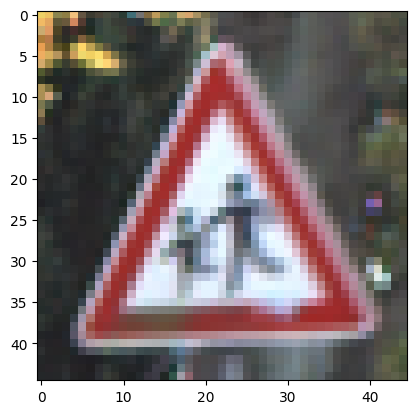

In [ ]:
plt.imshow(test_image)

In [ ]:
dummy_batch = test_image.reshape(1, image_size, image_size, 3)
print(dummy_batch.shape)
y = model.predict(dummy_batch)

(1, 45, 45, 3)
1/1 [==============================] - 1s 846ms/step


In [ ]:
print(y)
print(y.shape)

[[0.03056211 0.10396568 0.08209193 0.06169706 0.01270839 0.04558207
  0.01758037 0.02091255 0.02700447 0.01892263 0.01171179 0.03500436
  0.03034163 0.01545635 0.02060449 0.0045481  0.00631373 0.01361881
  0.00990784 0.00487156 0.02993089 0.03294541 0.00575319 0.07548595
  0.01427485 0.01681652 0.01437576 0.02450953 0.02763234 0.00840635
  0.01124598 0.02369562 0.00611553 0.0116646  0.01291677 0.01147998
  0.00711159 0.00879852 0.04246458 0.00550073 0.02180588 0.00888204
  0.00478143]]
(1, 43)


In [ ]:
print(np.round(y, 3))

[[0.031 0.104 0.082 0.062 0.013 0.046 0.018 0.021 0.027 0.019 0.012 0.035
  0.03  0.015 0.021 0.005 0.006 0.014 0.01  0.005 0.03  0.033 0.006 0.075
  0.014 0.017 0.014 0.025 0.028 0.008 0.011 0.024 0.006 0.012 0.013 0.011
  0.007 0.009 0.042 0.006 0.022 0.009 0.005]]


In [ ]:
predicted = np.argmax(y)
print(predicted)

1
